<a href="https://colab.research.google.com/github/biplovgautam/opencv/blob/main/HDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [56]:
def readImagesAndTimes():
    # List of file names
    filenames = ["3.jpeg", "2.jpeg", "1.jpeg"]

    # List of exposure times
    times = np.array([1 / 27, 1/17, 1.7], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

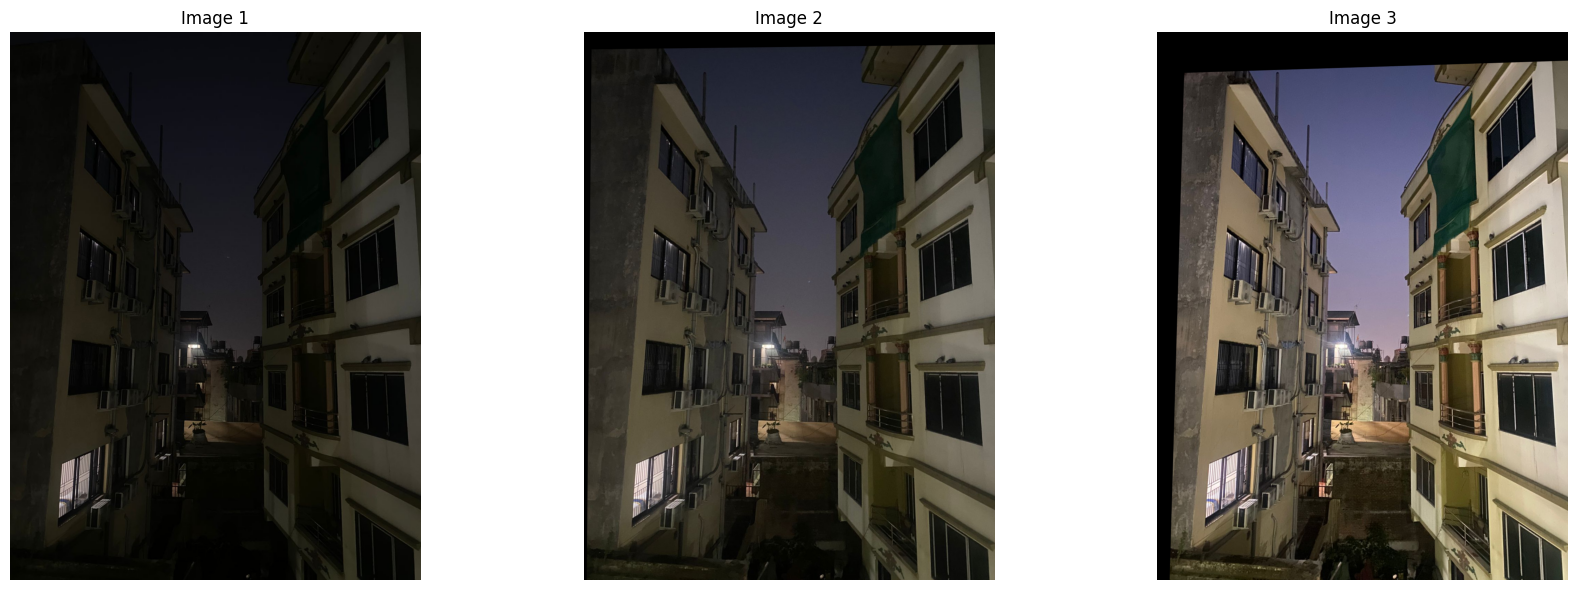

In [57]:
# # Read images and exposure times
# images, times = readImagesAndTimes()

# # Align Images
# alignMTB = cv2.createAlignMTB()
# alignMTB.process(images, images)


# def readImagesAndTimes():
#     filenames = ["3.jpeg", "2.jpeg", "1.jpeg"]
#     # You should replace these exposure times with actual values if known
#     times = np.array([1 / 17.0, 1 / 4.0, 1.0], dtype=np.float32)

#     images = [cv2.imread(f) for f in filenames]
#     return images, times

def align_images(base_img, img_to_align):
    gray_base = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
    gray_align = cv2.cvtColor(img_to_align, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(gray_base, None)
    kp2, des2 = orb.detectAndCompute(gray_align, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    aligned = cv2.warpPerspective(img_to_align, H, (base_img.shape[1], base_img.shape[0]))
    return aligned

# Read and align
images, times = readImagesAndTimes()
base_img = images[0]
aligned_images = [base_img] + [align_images(base_img, img) for img in images[1:]]
images = aligned_images  # Replace original list with aligned ones
# Convert to RGB for display and show in a row
plt.figure(figsize=(18, 6))
for i, img in enumerate(aligned_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

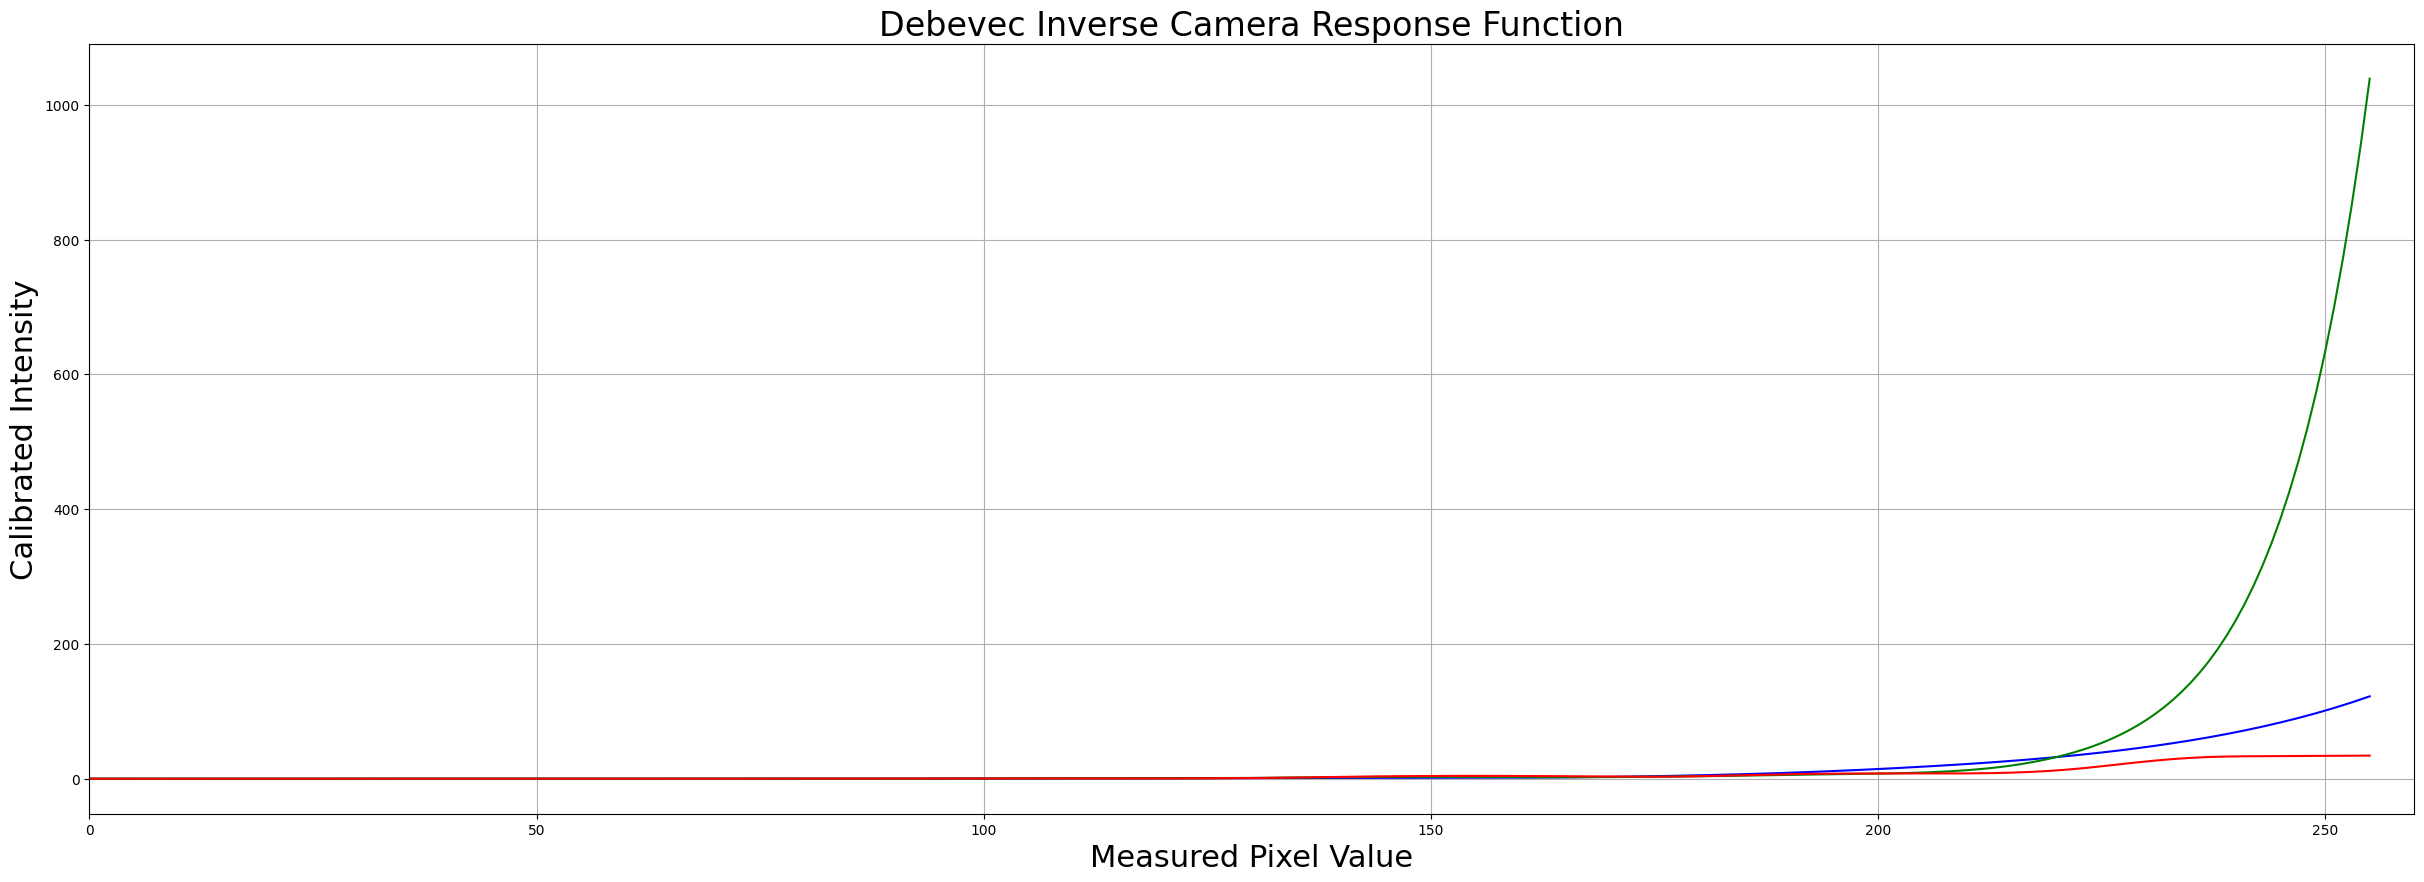

In [58]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")

In [59]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

In [60]:
# # Tonemap using Drago's method to obtain 24-bit color image
# tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
# ldrDrago = tonemapDrago.process(hdrDebevec)
# ldrDrago = 3 * ldrDrago

# # Saving image
# cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago)

# # Plotting image
# plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1]);plt.axis("off");

Tonemaping using Reinhard's method ... 


(np.float64(-0.5), np.float64(1199.5), np.float64(1599.5), np.float64(-0.5))

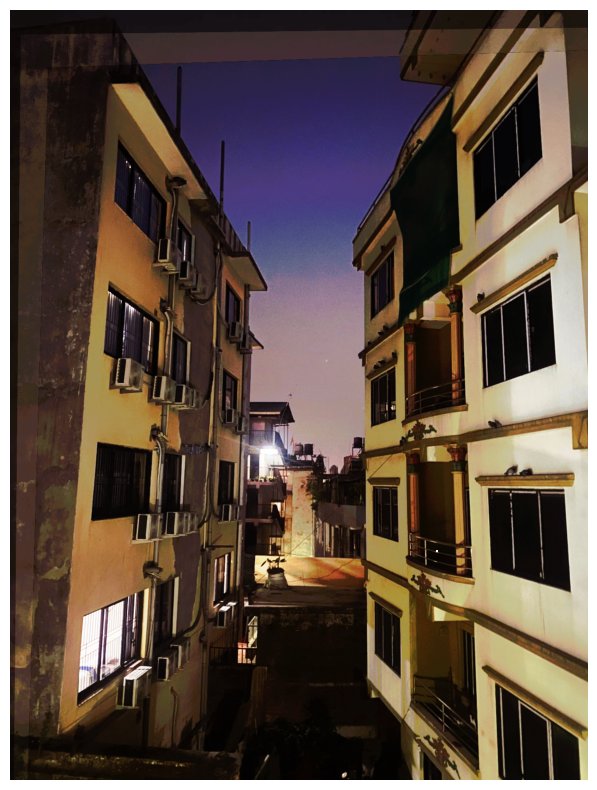

In [61]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

# Saving image
cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1)[:,:,::-1]);plt.axis("off")